# Utilities

In addition to the highly customizable plotters with complex grid layout, the `nested_grid_plotter` library provides a set of utilities, gathered in a subpackage named `utils`. These utilities do not require to use a plotter and can usually be used on classic [matplotlib](https://matplotlib.org/) `Axes`.

Note that the purpose of this library is simply to simplify some operations and to avoid code duplication. All the figures can be produced without this library, with matplotlib alone.

## Tutorial configuration

Let's start by importing the modules that we need

In [19]:
import nested_grid_plotter as ngp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

Check the versions being used:

In [20]:
print(f"matplotlib version = {mpl.__version__}")
print(f"nested_grid_plotter version = {ngp.__version__}")
print(f"numpy version = {np.__version__}")

matplotlib version = 3.9.0
nested_grid_plotter version = 1.1.2
numpy version = 1.25.2


Let's also apply some basic parameters for our figures so it looks nice.

In [21]:
new_rc_params = {
    "font.size": 16,
    "figure.figsize": (8, 8),
    "figure.facecolor": "w",
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
}
plt.rcParams.update(new_rc_params)

For the following tutorials, let's create a general function to generate such complex plot.

In [22]:
def gen_complex_example_fig():
    return ngp.NestedGridPlotter(
        fig_params={
            "constrained_layout": True,  # Always use this to prevent overlappings
            "figsize": (15, 6),
        },
        subfigs_params={"nrows": 1, "ncols": 2},
        subplots_mosaic_params={
            "the_left_sub_figure": dict(
                mosaic=[["lt1", "lt1"], ["lb1", "rb1"]],
                gridspec_kw=dict(height_ratios=[2, 1], width_ratios=[2, 1]),
                sharey=False,
            ),
            "the_right_sub_figure": dict(
                mosaic=[["l2", "rt2"], ["l2", "bt2"]],
                gridspec_kw=dict(height_ratios=[2, 1], width_ratios=[2, 1]),
                sharey=False,
            ),
        },
    )

## Replace non accepted parameter in paths

Make filename compatible with path (to save the figure) by replacaing anything that isn't alphanumeric, -, _, a space, a period, and brackets or parenthesis. Note that it combines multiple escaped characters into a single replacement.

In [23]:
badfilename = r"#6262%%this?is#\\my=plot*///name(km/h) "
print(ngp.replace_bad_path_characters(badfilename, repchar=" "))
print(ngp.replace_bad_path_characters(badfilename, repchar="_"))
print(ngp.replace_bad_path_characters(badfilename, repchar="-"))

6262 this is my plot name(km h)
6262_this_is_my_plot_name(km_h)
6262-this-is-my-plot-name(km-h)


## Add grids and configure thickparams
This adds a grid to a specific axis and offers the possibility to configure thick params. It takes the same input as `Axes.thick_params` with some default parameters.

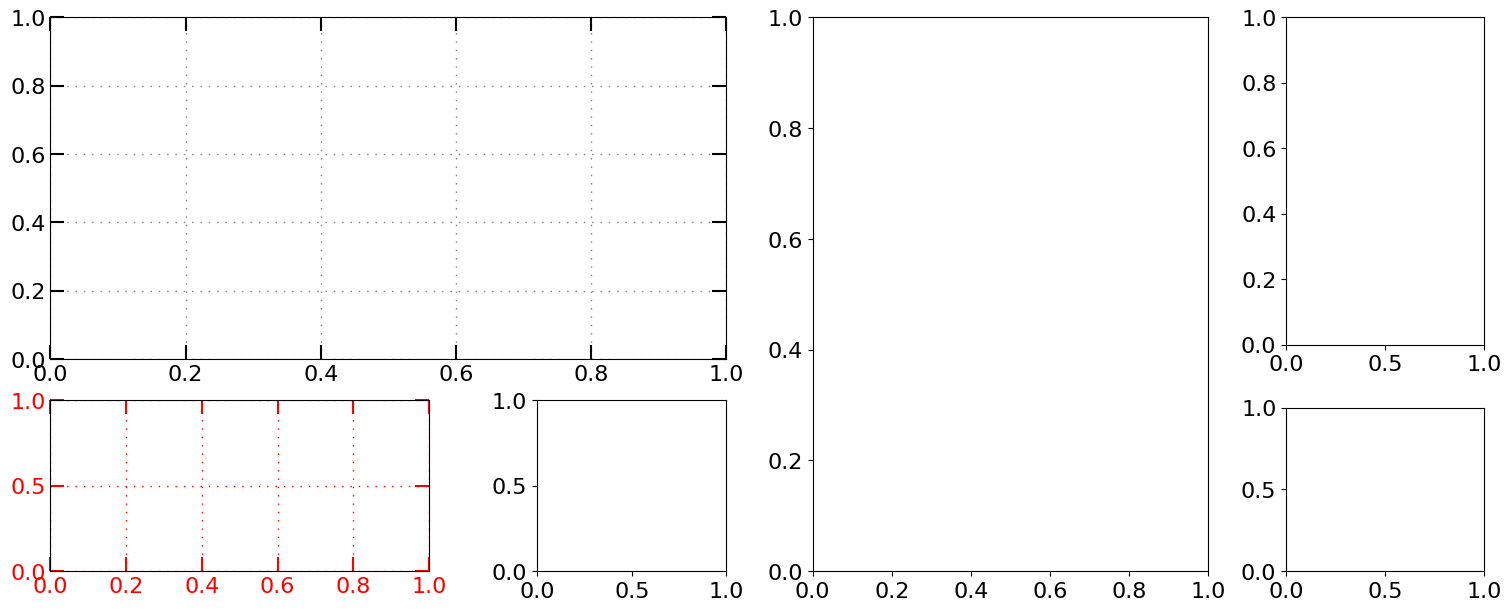

In [24]:
plotter = gen_complex_example_fig()
ngp.add_grid_and_tick_prams_to_axis(plotter.ax_dict["lt1"])
ngp.add_grid_and_tick_prams_to_axis(
    plotter.ax_dict["lb1"], colors="red", grid_color="red"
)

Also, a same grid can be applied to all subplots of the figure or of one of the subfigures.

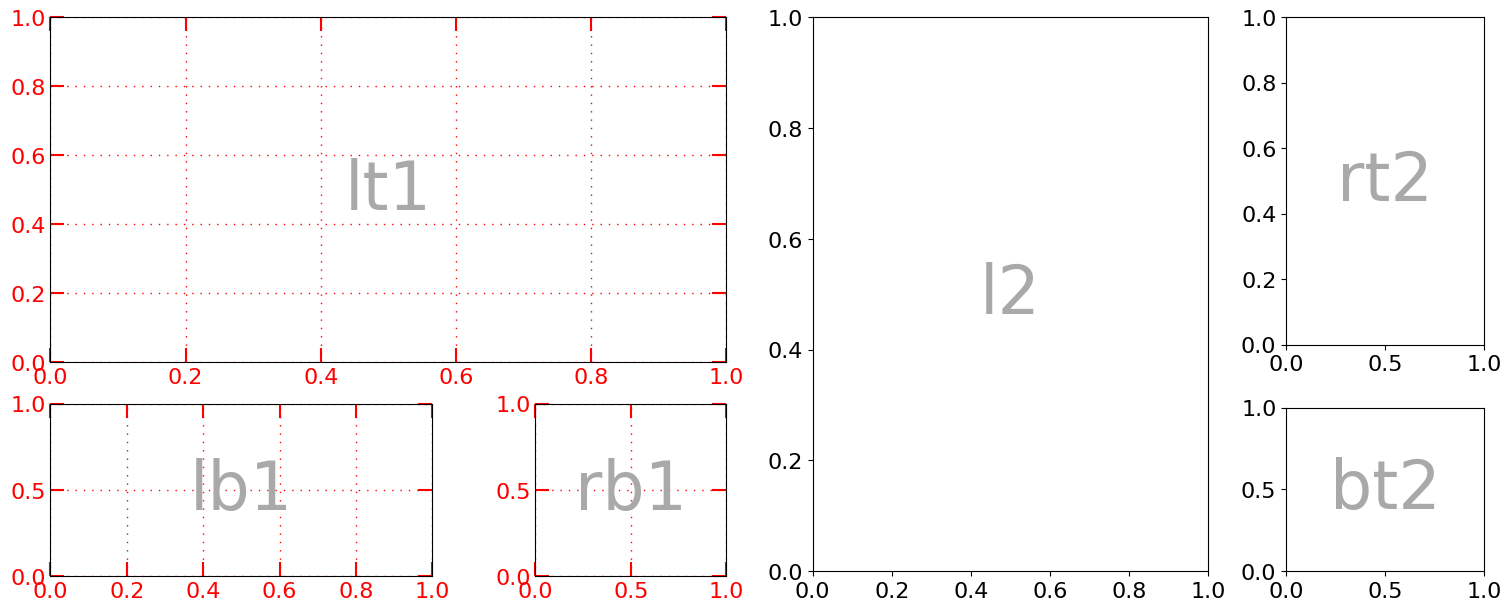

In [25]:
# Create a plot
plotter = gen_complex_example_fig()
plotter.identify_axes()  # Helper to add the name of the axis on the plot

# Add the grids
plotter.add_grid_and_tick_prams_to_all_axes(
    subfigure_name="the_left_sub_figure", colors="red", grid_color="red"
)

In [26]:
# Add the grids to all subfigures' plots
plotter.add_grid_and_tick_prams_to_all_axes(colors="blue", grid_color="blue", length=5)

Note that because the tick are red and thick, it has a quite weird effect when overlapping the frame of the plot. It can be easily removed by using a method `remove_axis_ticks_overlapping_axis_frame`. The labels are preserved, the ticks are just made invisible.

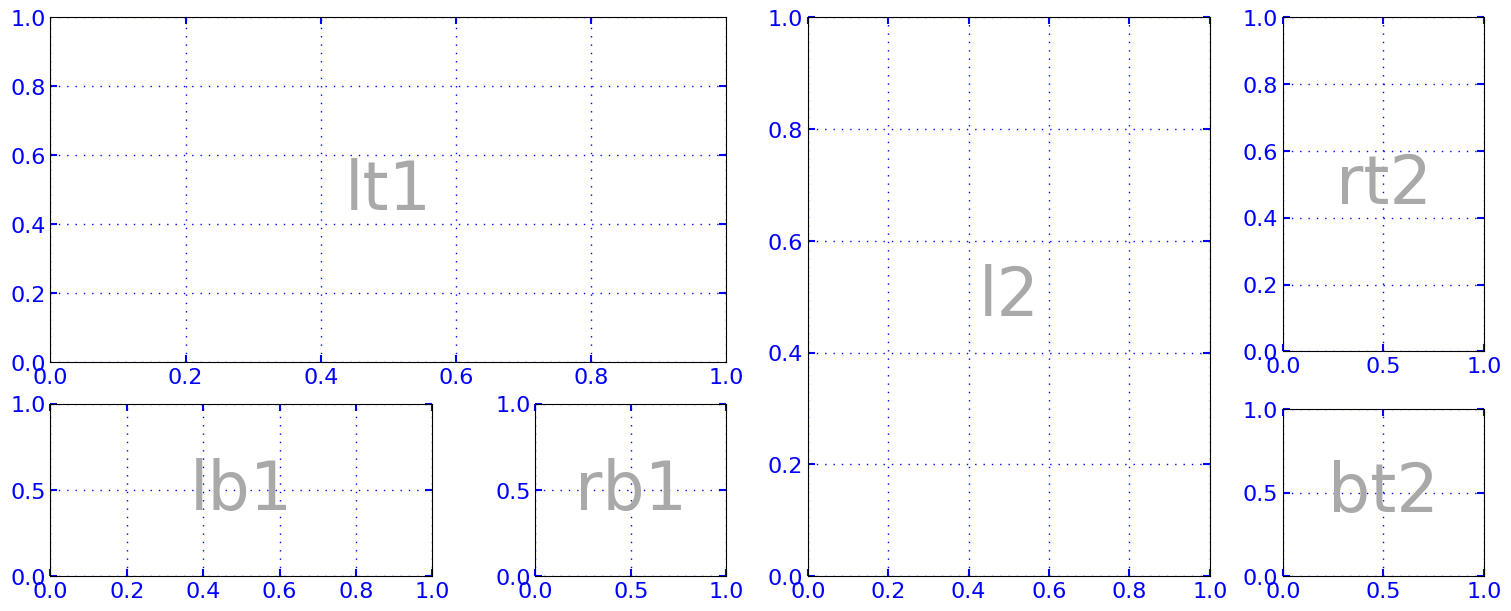

In [27]:
ngp.make_ticks_overlapping_axis_frame_invisible(plotter.ax_dict["lt1"])
plotter.fig  # display again

However, it needs to be performed only when the scale is fixed (i.e., no latter plot or manual adjustment modifies it) because if the scale of the axis is changed, the ticks are not updated and it might look weird. I haven't find a way to overcome this. 

In [28]:
plotter.ax_dict["lt1"].set_xlim(2.0, 4.0)

(2.0, 4.0)

### Hide ticks, ticklabels and spines

It is also possible to hide the ticks, ticklabels and spines with wrapping methods.
- `hide_axis_ticklabels` to hide the labels.
- Nothing special to hide the tick, the efault interface being already straightforward.
- `hide_axis_spine` to hide the spines.

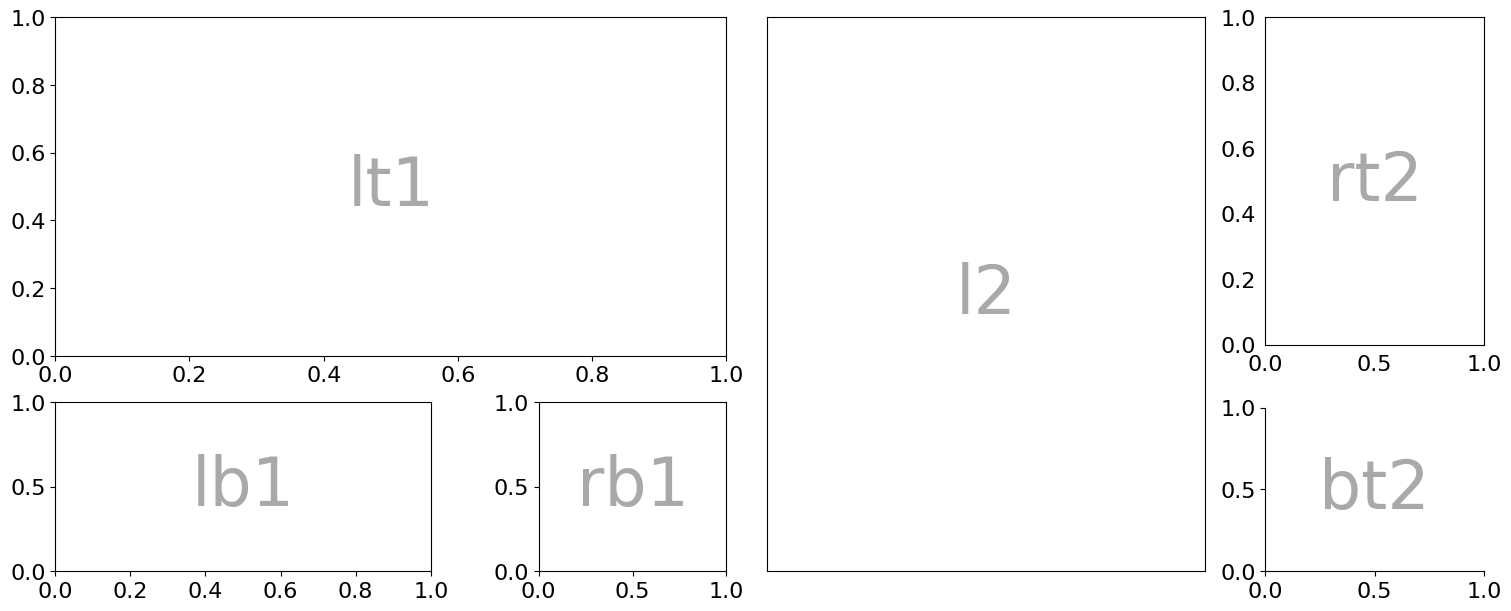

In [29]:
# Create a plot
plotter = gen_complex_example_fig()
plotter.identify_axes()  # Helper to add the name of the axis on the plot

# Remove the ticklabels in plot "l2" = We can also use 'both' to combine these two lines
ngp.hide_axis_ticklabels(plotter.ax_dict["l2"], "x")
ngp.hide_axis_ticklabels(plotter.ax_dict["l2"], "y")

# Remove the right and top ticks in plot 'rt2'
plotter.ax_dict["rt2"].tick_params(right=False, top=False, bottom=False, left=False)

# Remove the spines in plot 'bt2'
ngp.hide_axis_spine(plotter.ax_dict["bt2"], loc="top")
ngp.hide_axis_spine(plotter.ax_dict["bt2"], loc="right")
# plotter.hide_axis_spine("bt2", loc="left")
# plotter.hide_axis_spine("bt2", loc="bottom")
# plotter.hide_axis_spine("bt2", loc="all")  -> combines the four previous lines

## Align gridlines for two y-axis

Aligning gridlines for multiple y-axis is sometimes very useful. The NestedGridPlotter offers two herlper methods:
- `align_y_axes` which simply aligns ticks adding the minimum number of ticks as possible.
- `align_y_axis_on_values` which taken from [jason](https://stackoverflow.com/users/2005415/jason) answer on this [stackoverflow thread](https://stackoverflow.com/questions/26752464/how-do-i-align-gridlines-for-two-y-axis-scales-using-matplotlib) and works a bit differently. It allows to align one specific values for each axes.

Both support multiple axes.

Let's see two examples:


Text(0.5, 1.0, 'Specified alignment')

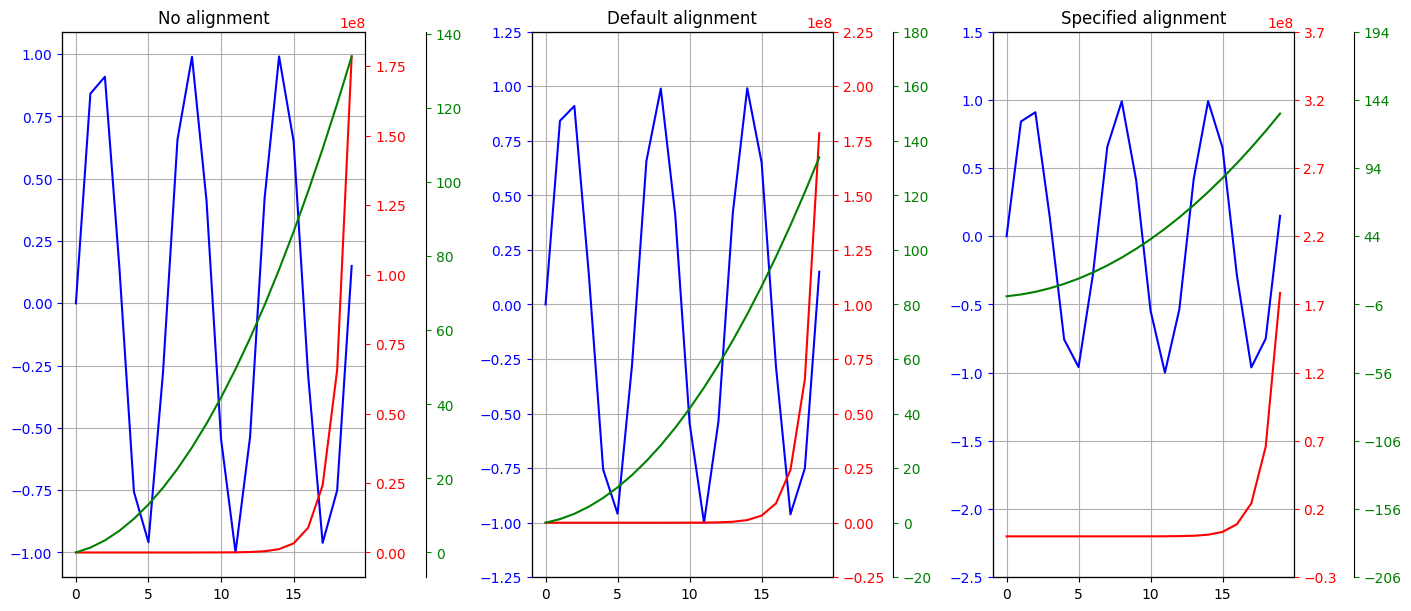

In [30]:
# craft some data to plot
x = np.arange(20)
y1 = np.sin(x)
y2 = x / 1000 + np.exp(x)
y3 = x + x**2 / 3.14

# Create a function to plot the data on one axis
from matplotlib.axes import Axes  # Just for liting
from typing import List


def plotLines(
    x: np.ndarray, y1: np.ndarray, y2: np.ndarray, y3: np.ndarray, ax: Axes
) -> List[Axes]:
    ax.plot(x, y1, "b-")
    ax.tick_params("y", colors="b")

    tax1 = ax.twinx()
    tax1.plot(x, y2, "r-")
    tax1.tick_params("y", colors="r")

    tax2 = ax.twinx()
    tax2.spines["right"].set_position(("axes", 1.2))
    # make_patch_spines_invisible(tax2)
    tax2.spines["right"].set_visible(True)
    tax2.plot(x, y3, "g-")
    tax2.tick_params("y", colors="g")

    ax.grid(True, axis="both")

    return [ax, tax1, tax2]


plt.rcParams.update({"font.size": 10})
plotter = ngp.NestedGridPlotter(
    fig_params={
        "constrained_layout": True,
        "figsize": (14, 6),
    },  # Always use this to prevent overlappings
    subfigs_params={"ncols": 3},
)

# Left plot: No alignment.
ax1 = plotter.ax_dict["ax1-1"]
axes1 = plotLines(x, y1, y2, y3, ax1)
ax1.set_title("No alignment")

# Mid plot: Aligned at (approximately) the lower bound of each y axis.
ax2 = plotter.ax_dict["ax1-2"]
axes2 = plotLines(x, y1, y2, y3, ax2)
ngp.align_y_axes(axes2)
ax2.set_title("Default alignment")

# Right plot: Aligned at specified values: 0 for blue, 2.2*1e8 for red, and 44 for green. Those are chosen arbitrarily for the example.
ax3 = plotter.ax_dict["ax1-3"]
axes3 = plotLines(x, y1, y2, y3, ax3)
ngp.align_y_axes_on_values(axes3, [0, 2.2 * 1e8, 44])
ax3.set_title("Specified alignment")

Note that if no args are given, then the default alignment might give undisired results.


Text(0.5, 1.0, 'Specific alignment with no values')

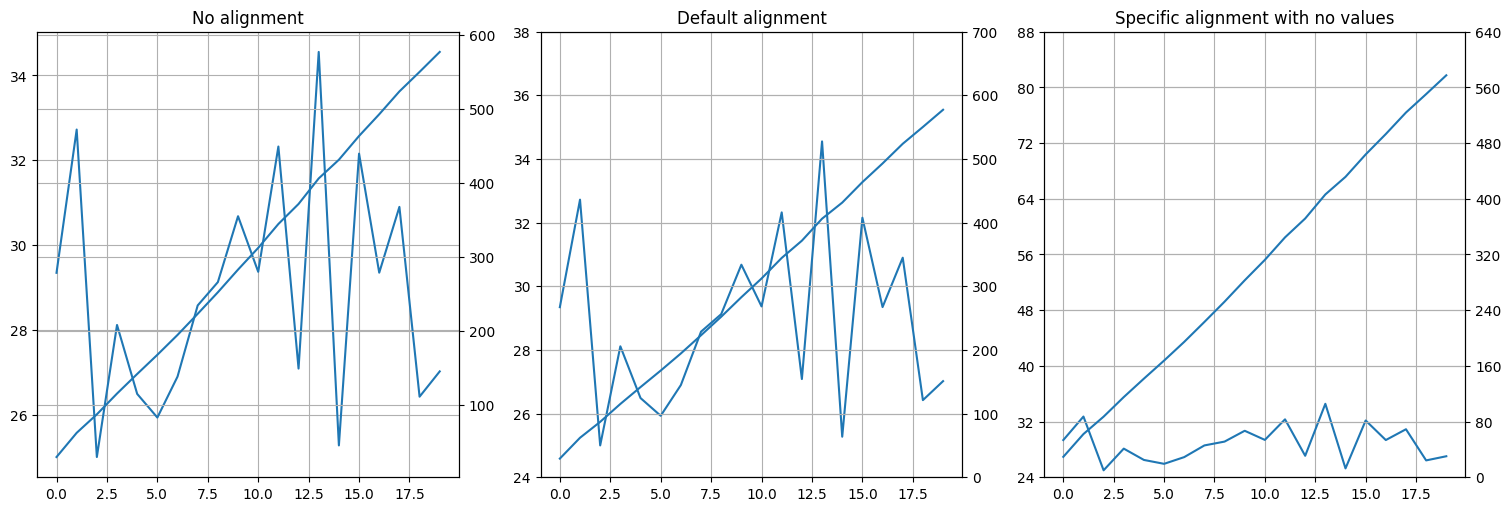

In [31]:
plotter = ngp.NestedGridPlotter(
    fig_params={
        "constrained_layout": True,
        "figsize": (15, 5),
    },  # Always use this to prevent overlappings
    subfigs_params={"ncols": 3},
)
# Make some data
np.random.seed(1)
data = (np.random.rand(20) + 5) ** 2
data_cum = data.cumsum()

# On the left figure, if we plot the data and its cumulative, the ticks on the y axes
# are not aligned
ax1 = plotter.ax_dict["ax1-1"]
ax1.plot(data)
twin_ax_1 = ax1.twinx()
twin_ax_1.plot(data_cum)
ax1.grid()
twin_ax_1.grid()
ax1.set_title("No alignment")

# This gives the optimal alignment
ax2 = plotter.ax_dict["ax1-2"]
ax2.plot(data)
ax2_twin = ax2.twinx()
ax2_twin.plot(data_cum)
ax2.grid()
ax2_twin.grid()
ngp.align_y_axes([ax2, ax2_twin])
ax2.set_title("Default alignment")

# This is not optimal
ax3 = plotter.ax_dict["ax1-3"]
ax3.plot(data)
ax3_twin = ax3.twinx()
ax3_twin.plot(data_cum)
ax3.grid()
ax3_twin.grid()
ngp.align_y_axes_on_values([ax3, ax3_twin])
ax3.set_title("Specific alignment with no values")

- Note the same can be achieved for the x axis with `ngp.align_x_axes_on_values`.

## Make x and y axes symmetric and centered to zero

- With the y axis (most frequent case)

([<matplotlib.lines.Line2D at 0x7cae43e08b50>,
 ['data1', 'data2'])

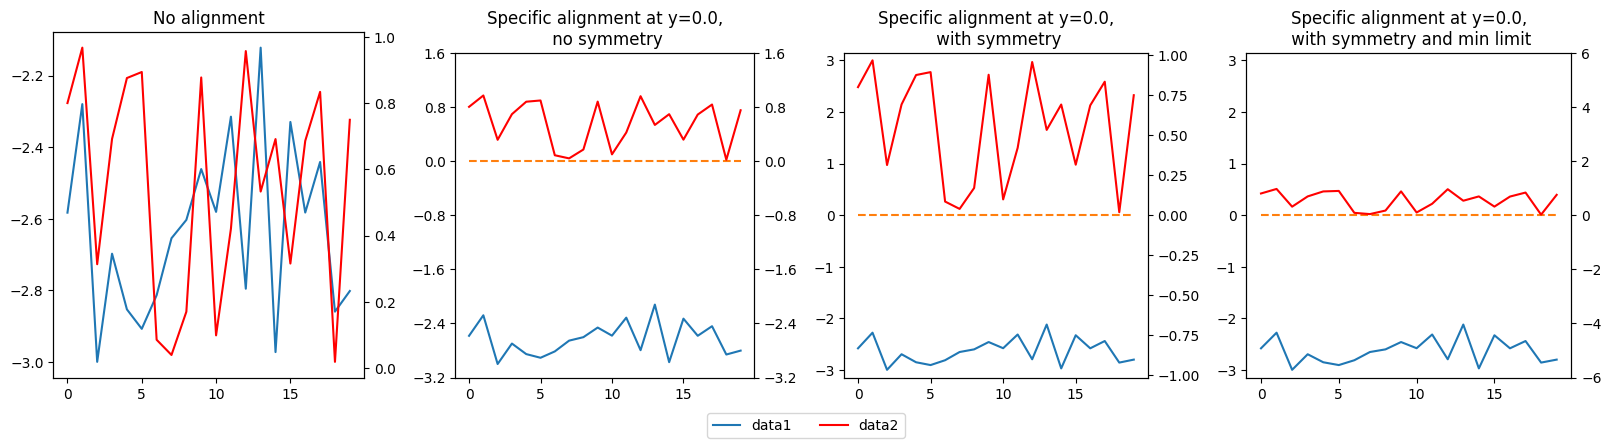

In [32]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (16, 4)},
    subfigs_params={"ncols": 4},
)

# Make some data
np.random.seed(1)
# data1 = np.random.normal(0,1,20)
data1 = np.random.rand(20) - 3
data2 = np.random.rand(20)
xy = np.zeros(20)

ax1 = plotter.ax_dict["ax1-1"]
ax1_twin = ax1.twinx()
ax1.plot(data1, label="data1")
ax1_twin.plot(data2, c="r", label="data2")
ax1.set_title("No alignment")

ax2 = plotter.ax_dict["ax1-2"]
ax2_twin = ax2.twinx()
ax2.plot(data1, label="data1")
ax2.plot(xy, linestyle="--")
ax2_twin.plot(data2, c="r", label="data2")
ngp.align_y_axes_on_values([ax2, ax2_twin], [0.0, 0.0])  # Works for more than 2 axes
ax2.set_title("Specific alignment at y=0.0,\n no symmetry")

ax3 = plotter.ax_dict["ax1-3"]
ax3_twin = ax3.twinx()
ax3.plot(data1, label="data1")
ax3.plot(xy, linestyle="--")
ax3_twin.plot(data2, c="r", label="data2")
ngp.make_y_axes_symmetric_zero_centered([ax3, ax3_twin])  # Works for more than 2 axes
ax3.set_title("Specific alignment at y=0.0,\n with symmetry")

ax4 = plotter.ax_dict["ax1-4"]
ax4_twin = ax4.twinx()
ax4.plot(data1, label="data1")
ax4.plot(xy, linestyle="--")
ax4_twin.plot(data2, c="r", label="data2")
# Here we impose a range of at least [-0.5, 0.5] for the blue curve,
# and of [-6, 6] for the red curve
ngp.make_y_axes_symmetric_zero_centered([ax4, ax4_twin], min_ylims=[0.5, 6.0])
ax4.set_title("Specific alignment at y=0.0,\n with symmetry and min limit")

plotter.add_fig_legend(fontsize=10, ncol=2)

- With the x axis (more exotic)

([<matplotlib.lines.Line2D at 0x7cae43c10b50>,
 ['data1', 'data2'])

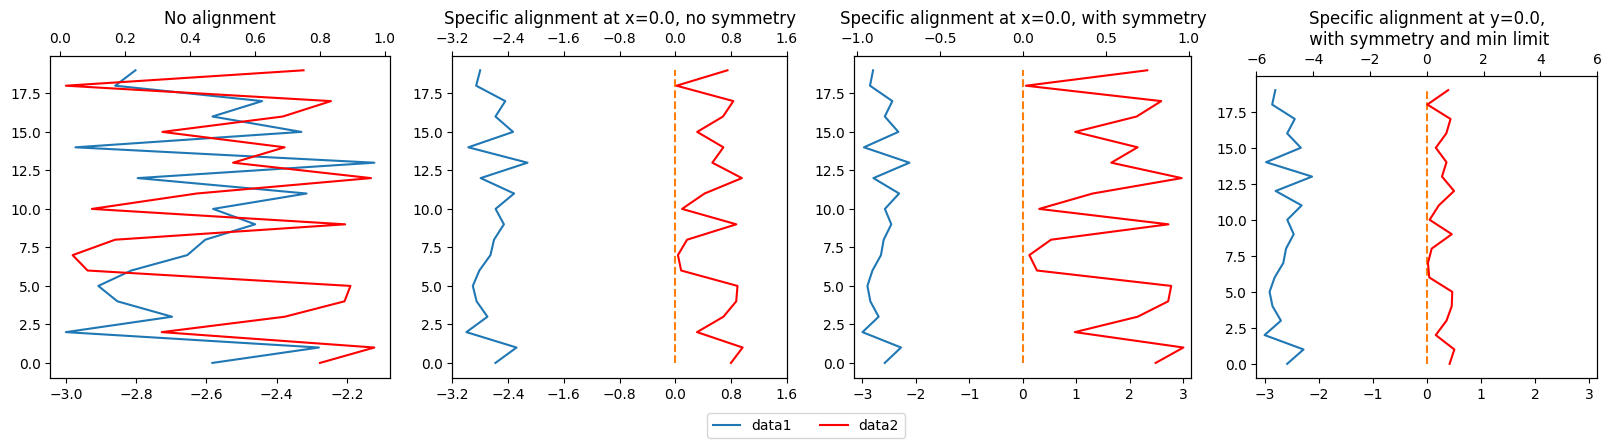

In [33]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (16, 4)},
    subfigs_params={"ncols": 4},
)

# Make some data
np.random.seed(1)
# data1 = np.random.normal(0,1,20)
x_data1 = np.random.rand(20) - 3
x_data2 = np.random.rand(20)
y_data = np.arange(x_data1.size)
xy = np.zeros(20)

ax1 = plotter.ax_dict["ax1-1"]
ax1_twin = ax1.twiny()
ax1.plot(x_data1, y_data, label="data1")
ax1_twin.plot(x_data2, y_data, c="r", label="data2")
ax1.set_title("No alignment")

ax2 = plotter.ax_dict["ax1-2"]
ax2_twin = ax2.twiny()
ax2.plot(x_data1, y_data, label="data1")
ax2.plot(xy, y_data, linestyle="--")
ax2_twin.plot(x_data2, y_data, c="r", label="data2")
ngp.align_x_axes_on_values([ax2, ax2_twin], [0.0, 0.0])  # Works for more than 2 axes
ax2.set_title("Specific alignment at x=0.0, no symmetry")

ax3 = plotter.ax_dict["ax1-3"]
ax3_twin = ax3.twiny()
ax3.plot(x_data1, y_data, label="data1")
ax3.plot(xy, y_data, linestyle="--")
ax3_twin.plot(x_data2, y_data, c="r", label="data2")
ngp.make_x_axes_symmetric_zero_centered([ax3, ax3_twin])  # Works for more than 2 axes
ax3.set_title("Specific alignment at x=0.0, with symmetry")

ax4 = plotter.ax_dict["ax1-4"]
ax4_twin = ax4.twiny()
ax4.plot(x_data1, y_data, label="data1")
ax4.plot(xy, y_data, linestyle="--")
ax4_twin.plot(x_data2, y_data, c="r", label="data2")
# Here we impose a range of at least [-0.5, 0.5] for the blue curve,
# and of [-6, 6] for the red curve
ngp.make_x_axes_symmetric_zero_centered([ax4, ax4_twin], min_xlims=[0.5, 6.0])
ax4.set_title("Specific alignment at y=0.0,\n with symmetry and min limit")

plotter.add_fig_legend(fontsize=10, ncol=2)

## Add a date axis

It is sometimes painful to combine dates and number of days. I frequently used it o I wanted to included it in the library.
Not that the time_unit and the format are totally independent, the first beinginvolve in computing the date, the secondonly for display. Even if this is not necessary, it is possible to add multiple date axes. Note that `add_xaxis_twin_as_date` is deprecated since v1.2.

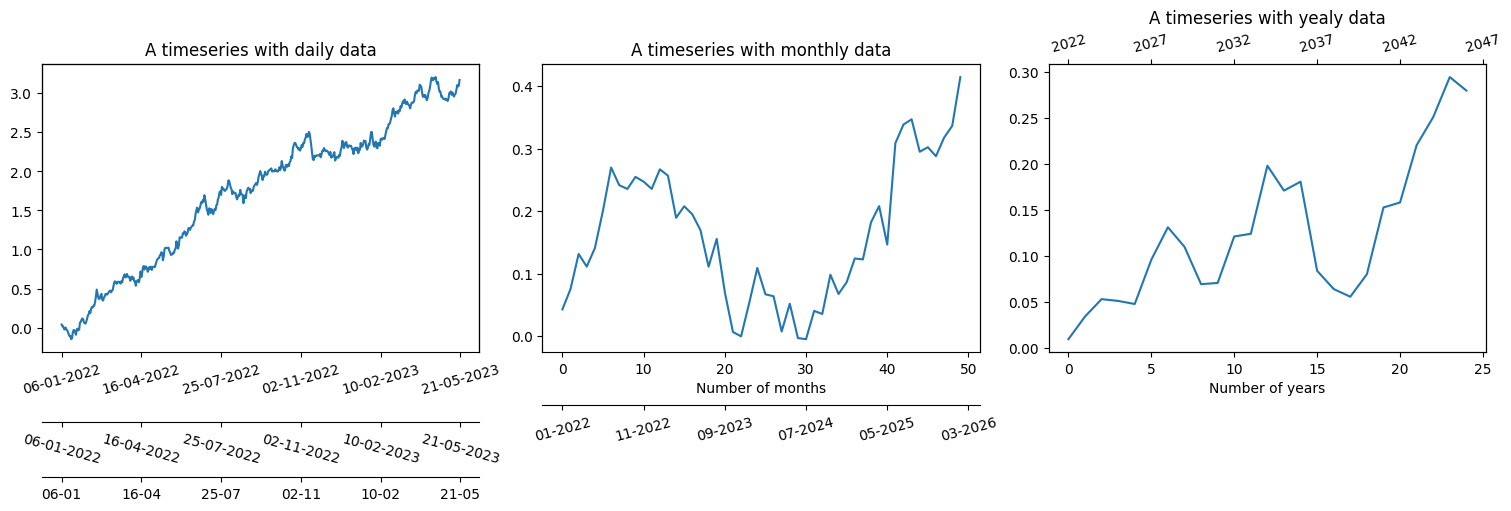

In [34]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]])},
)

# Plot the data
ax1 = plotter.ax_dict["ax1-1"]
ax1.plot(np.cumsum(0.004 + 0.04 * np.random.randn(100, 5)))
ax1.set_title("A timeseries with daily data")

# You can either transform the existing axis
ngp.ticklabels_to_datetime(
    ax1,
    initial_datetime=datetime(2022, 1, 6),
    is_y_axis=False,
    step=relativedelta(days=1),
    format="%d-%m-%Y",
    rotation_degrees=15,
)

# Or add a second one
ngp.add_twin_axis_as_datetime(
    ax1,
    initial_datetime=datetime(2022, 1, 6),
    step=relativedelta(days=1),
    format="%d-%m-%Y",
    rotation_degrees=-15,  # rotation the other way around
    spine_outward_position=50,  # relative to ax11
)

# And even a third one with a rotation
ax113 = ngp.add_twin_axis_as_datetime(
    ax1,
    initial_datetime=datetime(2022, 1, 6),
    step=relativedelta(days=1),
    format="%d-%m",
    spine_outward_position=90,  # relative to ax11
    rotation_degrees=0,
)

# Plot the data
ax2 = plotter.ax_dict["ax1-2"]
ax2.plot(np.cumsum(0.004 + 0.04 * np.random.randn(10, 5)))
ax2.set_title("A timeseries with monthly data")
ax2.set_xlabel("Number of months")

# And on the third graphic, same with years and above the graphic
ax22 = ngp.add_twin_axis_as_datetime(
    ax2,
    initial_datetime=datetime(2022, 1, 6),
    step=relativedelta(months=1),
    format="%m-%Y",
    spine_outward_position=38,
)

# Plot the data
ax3 = plotter.ax_dict["ax1-3"]
ax3.plot(np.cumsum(0.004 + 0.04 * np.random.randn(5, 5)))
ax3.set_title("A timeseries with yealy data")
ax3.set_xlabel("Number of years")

# Add a date x axis
ax3 = ngp.add_twin_axis_as_datetime(
    ax3,
    initial_datetime=datetime(2022, 1, 6),
    step=relativedelta(years=1),
    format="%Y",
    spine_outward_position=0,
    position="top",
    is_hide_opposed_tick_labels=False,
)

## Add letters to frames

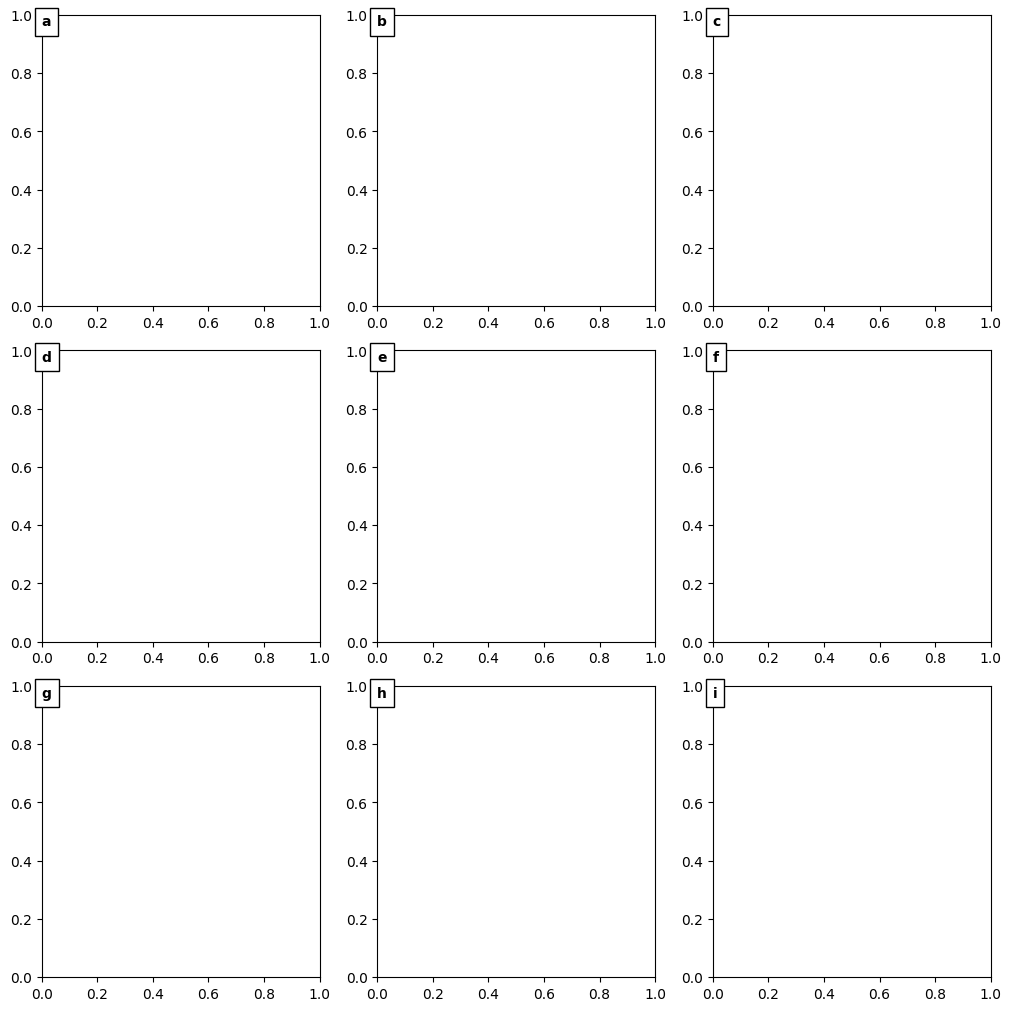

In [35]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 10)},
    subfigs_params={"ncols": 3, "nrows": 3},
)
ngp.add_letter_to_frames(plotter.axes)

- If the number of frames (axes) is above 26 (the number of letter in the latin alphabet) than a suffix number is added.

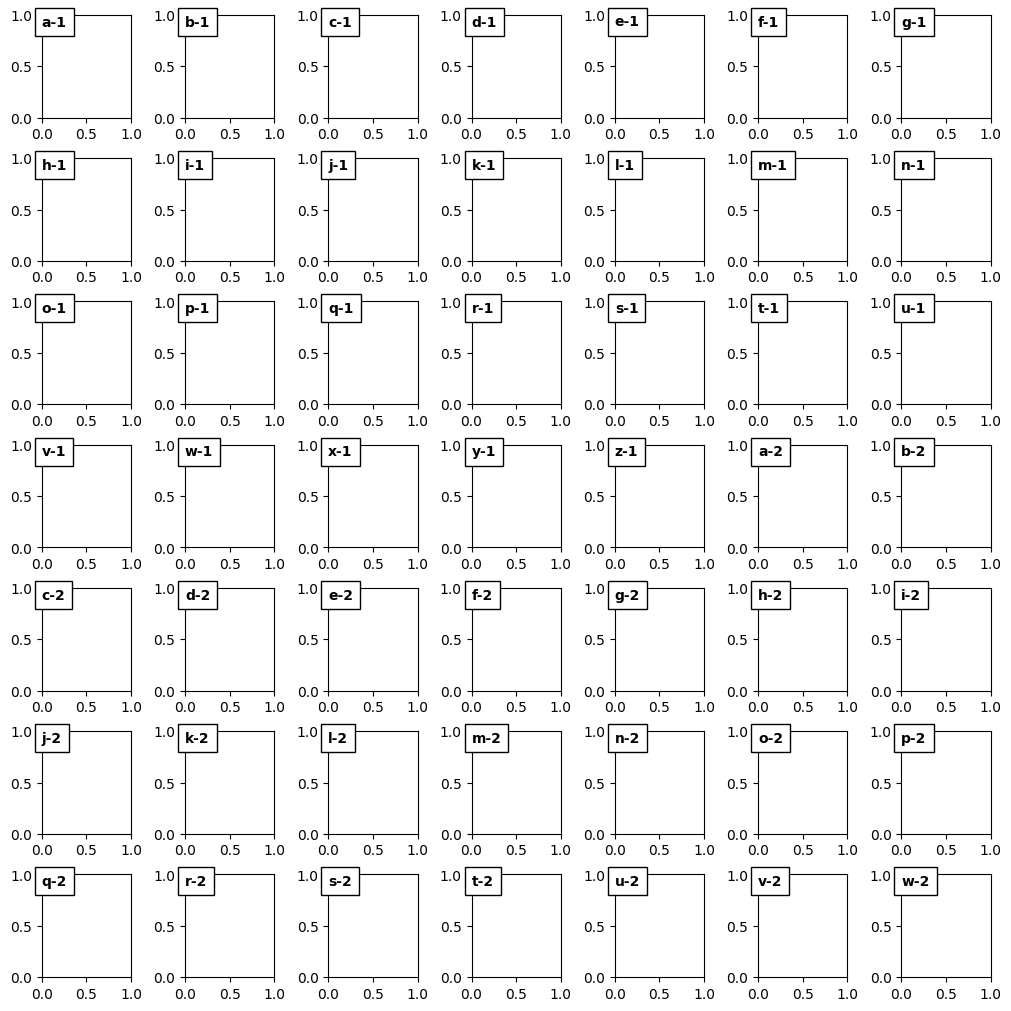

In [36]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 10)},
    subfigs_params={"ncols": 7, "nrows": 7},
)
ngp.add_letter_to_frames(plotter.axes)